# Importing required libraries 

In [1]:
from kiteconnect import KiteConnect,KiteTicker
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import os 
import time
from time import sleep 
import statsmodels.api as sm
from pyotp import TOTP
from datetime import datetime
from urllib.parse import urlparse,parse_qs
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import plotly.graph_objects as go
from datetime import timedelta
import mplfinance as mpf

In [2]:
def get_curr_path(folder_name):
    curr_dir = os.getcwd()
    curr_path = os.path.join(curr_dir,folder_name)
    return curr_path

def get_credentials(curr_path,file_name):
    file_dir = os.path.join(curr_path,file_name)
    file = open(file_dir,'r').read().split()
    api_key = file[0]
    api_secret = file[1]
    user_name = file[2]
    pwd = file[3]
    totp_key = file[-1]
    return api_key,api_secret,user_name,pwd,totp_key

def auto_login(api_key,user_name,pwd,totp_key):
    kite = KiteConnect(api_key=api_key)
    service = Service(ChromeDriverManager().install())
    service.start()
    options = Options()
    options.to_capabilities()
    driver = webdriver.Remote(
        command_executor=service.service_url,
        options=options)
    driver.get(kite.login_url())
    driver.implicitly_wait(5)
    username = driver.find_element(By.XPATH, "//input[@type='text']")
    username.send_keys(user_name)
    password = driver.find_element(By.XPATH, "//input[@type='password']")
    password.send_keys(pwd)
    driver.find_element(By.XPATH, "//button[@type='submit']").click()
    sleep(1)
    totp = driver.find_element(By.XPATH,"//input[@type='number']")
    totp_token = TOTP(totp_key)
    token = totp_token.now()
    totp.send_keys(token)
    driver.find_element(By.XPATH,"//button[@type = 'submit']").click()
    sleep(1)
    current_url = driver.current_url
    parsed_url = urlparse(current_url)
    query_params = parse_qs(parsed_url.query)
    request_token = query_params.get('request_token',[None])[0]
    with open('request_token.txt', 'w') as f:
        f.write(request_token)
    request_token = open('request_token.txt','r').read()
    driver.quit()
    return request_token
    

def generate_access_token(request_token,api_key,api_secret):
    request_token = open('request_token.txt','r').read()
    kite = KiteConnect(api_key=api_key)
    data = kite.generate_session(request_token=request_token,api_secret=api_secret)
    data
    with open('access_token.txt','w') as f:
        f.write(data['access_token'])
    access_token = open('access_token.txt','r').read()
    return access_token

# Automating the login in zerodha 

In [3]:
folder_name = 'api_keys'
curr_dir = get_curr_path(folder_name)

file_name = 'credentials.txt'
api_key,api_secret,user_name,pwd,totp_key = get_credentials(curr_dir,file_name)

request_token = auto_login(api_key,user_name,pwd,totp_key)

access_token = generate_access_token(request_token,api_key,api_secret)

# Setting up the access token to execute buy,sell orders

In [4]:
kite = KiteConnect(api_key=api_key)
kite.set_access_token(access_token=access_token)

In [5]:
instrument_dump = kite.instruments('NSE')
instrument_df = pd.DataFrame(instrument_dump)
instrument_df.to_csv('NSE_instruments.csv',index=False)

In [6]:
def tokenLookup(instrument_df,symbol_list):
    """Looks up instrument token for a given script from instrument dump"""
    token_list = []
    for symbol in symbol_list:
        token_list.append(int(instrument_df[instrument_df.tradingsymbol==symbol].instrument_token.values[0]))
    return token_list

def tickerLookup(token):
    global instrument_df
    return instrument_df[instrument_df.instrument_token==token].tradingsymbol.values[0] 

def instrumentLookup(instrument_df,symbol):
    """Looks up instrument token for a given script from instrument dump"""
    try:
        return instrument_df[instrument_df.tradingsymbol==symbol].instrument_token.values[0]
    except:
        return -1

def fetchOHLC(ticker,interval,duration):
    """extracts historical data and outputs in the form of dataframe"""
    instrument = instrumentLookup(instrument_df,ticker)
    data = pd.DataFrame(kite.historical_data(instrument,dt.date.today()-dt.timedelta(duration), dt.date.today(),interval))
    data.set_index("date",inplace=True)
    return data

def fetchOHLCExtended(ticker, inception_date, interval):
    """Extracts historical data and outputs in the form of a DataFrame.
       inception_date string format - dd-mm-yyyy"""
    instrument = instrumentLookup(instrument_df, ticker)
    from_date = dt.datetime.strptime(inception_date, '%d-%m-%Y')
    data = pd.DataFrame()  # Start with an empty DataFrame
    while True:
        if from_date.date() >= (dt.date.today() - dt.timedelta(100)):
            new_data = pd.DataFrame(kite.historical_data(instrument, from_date, dt.date.today(), interval))
            if not new_data.empty:
                if data.empty:
                    data = new_data
                else:
                    data = pd.concat([data, new_data], ignore_index=True)
            break
        else:
            to_date = from_date + dt.timedelta(100)
            new_data = pd.DataFrame(kite.historical_data(instrument, from_date, to_date, interval))
            if not new_data.empty:
                if data.empty:
                    data = new_data
                else:
                    data = pd.concat([data, new_data], ignore_index=True)
            from_date = to_date
    
    if not data.empty:
        data.set_index("date", inplace=True)
    return data



# Extracting 5 minute interval data of infosys stock

In [7]:
ohlc = fetchOHLCExtended("INFY", "31-12-2022", 'day')

In [8]:
print(ohlc.shape)
ohlc.head()

(367, 5)


,open,high,low,close,volume
date,,,,,
2023-01-02 00:00:00+05:30,1514.00,1526.50,1504.05,1524.00,3801140
2023-01-03 00:00:00+05:30,1519.85,1532.65,1515.10,1522.55,4551130
2023-01-04 00:00:00+05:30,1521.00,1521.00,1491.10,1494.80,7059590
2023-01-05 00:00:00+05:30,1505.90,1505.90,1469.25,1475.20,9868404
2023-01-06 00:00:00+05:30,1470.00,1475.00,1446.50,1448.50,6443714


# Computing the technical indicators 

<h3>Computing Exponential Moving Average</h3>
<ol>
    <li>There are three steps to calculate the EMA:</li>
    <li>Calculate the Simple Moving Average (SMA)</li>
    <li>Compute Multiplier = (2 / (n + 1))</li>
    <li>For the first EMA, use the SMA of the previous day. For subsequent EMAs, use:
        <br>EMA = {Close - EMA(previous day)} x Multiplier + EMA(previous day)
    </li>
</ol>

<h3>Procedure to Compute MACD</h3>
<ol>
    <li>MACD Line: (12-day EMA - 26-day EMA)</li>
    <li>Signal Line: 9-day EMA of the MACD Line</li>
    <li>MACD Histogram: MACD Line - Signal Line</li>
</ol>


In [9]:
temp_df = ohlc.copy()
temp_df.head()

,open,high,low,close,volume
date,,,,,
2023-01-02 00:00:00+05:30,1514.00,1526.50,1504.05,1524.00,3801140
2023-01-03 00:00:00+05:30,1519.85,1532.65,1515.10,1522.55,4551130
2023-01-04 00:00:00+05:30,1521.00,1521.00,1491.10,1494.80,7059590
2023-01-05 00:00:00+05:30,1505.90,1505.90,1469.25,1475.20,9868404
2023-01-06 00:00:00+05:30,1470.00,1475.00,1446.50,1448.50,6443714


In [10]:
def compute_sma(df,n1,n2):
    df = df.copy()
    df['short_sma'] = df['close'].rolling(n1).mean()
    df['long_sma'] = df['close'].rolling(n2).mean()
    return df

In [11]:
temp_df = compute_sma(temp_df,n1=8,n2=20)

In [12]:
def compute_ema(df,n,column_name):
    df = df.copy()
    df[column_name] = np.nan
    df.loc[df.index[n-1], column_name] = df['close'][:n].mean()
    multiplier = 2 / (n + 1)
    for i in range(n,len(df)):
        df.loc[df.index[i],column_name] = (df.loc[df.index[i],'close'] - df.loc[df.index[i - 1],column_name]) * multiplier + df.loc[df.index[i - 1],column_name]
    return df

In [13]:
temp_df = compute_ema(temp_df,12,'fast_ma')
temp_df = compute_ema(temp_df,26,'slow_ma')
temp_df['macd'] = temp_df['fast_ma'] - temp_df['slow_ma']

In [14]:
temp_df.tail()

,open,high,low,close,volume,short_sma,long_sma,fast_ma,slow_ma,macd
date,,,,,,,,,,
2024-06-26 00:00:00+05:30,1541.00,1548.85,1535.00,1540.70,4851004,1519.54375,1482.590,1511.705415,1489.645483,22.059933
2024-06-27 00:00:00+05:30,1538.45,1578.40,1532.05,1573.35,14757754,1530.10000,1488.710,1521.189198,1495.845817,25.343380
2024-06-28 00:00:00+05:30,1572.55,1588.50,1564.25,1566.75,8197544,1538.66875,1495.675,1528.198552,1501.097979,27.100573
2024-07-01 00:00:00+05:30,1559.50,1599.90,1559.50,1590.80,6801771,1548.60000,1504.870,1537.829544,1507.742573,30.086971
2024-07-02 00:00:00+05:30,1596.20,1631.50,1586.50,1629.60,4840557,1562.87500,1516.055,1551.948076,1516.769049,35.179026


In [15]:
def compute_signal(df, n):
    df = df.copy()
    df['signal'] = np.nan
    
    first_valid_index = df['macd'].first_valid_index()
    if first_valid_index is None:
        raise ValueError("MACD column contains only NaN values.")
    
    start_index = df.index.get_loc(first_valid_index) + n - 1
    if start_index < len(df):
        df.loc[df.index[start_index], 'signal'] = df['macd'].iloc[start_index - n + 1:start_index + 1].mean()
    multiplier = 2 / (n + 1)
    for i in range(start_index + 1, len(df)):
        df.loc[df.index[i], 'signal'] = ((df.loc[df.index[i], 'macd'] - df.loc[df.index[i - 1], 'signal']) 
                                          * multiplier) + df.loc[df.index[i - 1], 'signal']   
    return df

In [16]:
temp_df = compute_signal(temp_df,9)
temp_df.tail()

,open,high,low,close,volume,short_sma,long_sma,fast_ma,slow_ma,macd,signal
date,,,,,,,,,,,
2024-06-26 00:00:00+05:30,1541.00,1548.85,1535.00,1540.70,4851004,1519.54375,1482.590,1511.705415,1489.645483,22.059933,15.609218
2024-06-27 00:00:00+05:30,1538.45,1578.40,1532.05,1573.35,14757754,1530.10000,1488.710,1521.189198,1495.845817,25.343380,17.556050
2024-06-28 00:00:00+05:30,1572.55,1588.50,1564.25,1566.75,8197544,1538.66875,1495.675,1528.198552,1501.097979,27.100573,19.464955
2024-07-01 00:00:00+05:30,1559.50,1599.90,1559.50,1590.80,6801771,1548.60000,1504.870,1537.829544,1507.742573,30.086971,21.589358
2024-07-02 00:00:00+05:30,1596.20,1631.50,1586.50,1629.60,4840557,1562.87500,1516.055,1551.948076,1516.769049,35.179026,24.307292


In [17]:
temp_df['macd_histogram'] = temp_df['macd'] - temp_df['signal']
temp_df.tail()

,open,high,low,close,volume,short_sma,long_sma,fast_ma,slow_ma,macd,signal,macd_histogram
date,,,,,,,,,,,,
2024-06-26 00:00:00+05:30,1541.00,1548.85,1535.00,1540.70,4851004,1519.54375,1482.590,1511.705415,1489.645483,22.059933,15.609218,6.450715
2024-06-27 00:00:00+05:30,1538.45,1578.40,1532.05,1573.35,14757754,1530.10000,1488.710,1521.189198,1495.845817,25.343380,17.556050,7.787330
2024-06-28 00:00:00+05:30,1572.55,1588.50,1564.25,1566.75,8197544,1538.66875,1495.675,1528.198552,1501.097979,27.100573,19.464955,7.635618
2024-07-01 00:00:00+05:30,1559.50,1599.90,1559.50,1590.80,6801771,1548.60000,1504.870,1537.829544,1507.742573,30.086971,21.589358,8.497613
2024-07-02 00:00:00+05:30,1596.20,1631.50,1586.50,1629.60,4840557,1562.87500,1516.055,1551.948076,1516.769049,35.179026,24.307292,10.871735


In [18]:
temp_df.drop(columns=['fast_ma','slow_ma'],axis=1,inplace=True)

In [19]:
temp_df.tail()

,open,high,low,close,volume,short_sma,long_sma,macd,signal,macd_histogram
date,,,,,,,,,,
2024-06-26 00:00:00+05:30,1541.00,1548.85,1535.00,1540.70,4851004,1519.54375,1482.590,22.059933,15.609218,6.450715
2024-06-27 00:00:00+05:30,1538.45,1578.40,1532.05,1573.35,14757754,1530.10000,1488.710,25.343380,17.556050,7.787330
2024-06-28 00:00:00+05:30,1572.55,1588.50,1564.25,1566.75,8197544,1538.66875,1495.675,27.100573,19.464955,7.635618
2024-07-01 00:00:00+05:30,1559.50,1599.90,1559.50,1590.80,6801771,1548.60000,1504.870,30.086971,21.589358,8.497613
2024-07-02 00:00:00+05:30,1596.20,1631.50,1586.50,1629.60,4840557,1562.87500,1516.055,35.179026,24.307292,10.871735


<h3>Procedure for calculating the rsi</h3>
<ol>
  <li><b>Formula for RSI</b>:
    <br>RSI = 100 - 100 / (1 + RS)
  </li>
  <li><b>Calculation of RS (Relative Strength)</b>:
    <br>RS = Average Gain of n days UP / Average Loss of n days DOWN
  </li>
  <li><b>Determine Change</b>:
    <br>change = change(close)
  </li>
  <li><b>Calculate Gain</b>:
    <br>gain = change >= 0 ? change : 0.0
  </li>
  <li><b>Calculate Loss</b>:
    <br>loss = change < 0 ? (-1) * change : 0.0
  </li>
  <li><b>Compute Average Gain</b>:
    <br>avgGain = rma(gain, 14)
    <br>- rma denotes the running moving average.
  </li>
  <li><b>Compute Average Loss</b>:
    <br>avgLoss = rma(loss, 14)
  </li>
  <li><b>Calculate RS</b>:
    <br>rs = avgGain / avgLoss
  </li>
  <li><b>Calculate RSI</b>:
    <br>rsi = 100 - (100 / (1 + rs))
  </li>
  <li><b>RSI Equivalence</b>:
    <br>The calculated RSI value, as shown above, is exactly equal to:
    <br>rsi(close, 14)
  </li>
</ol>


In [20]:
def compute_rsi(df,n):
    df = df.copy()
    df['close_diff'] = df['close'].diff().dropna()
    # df.dropna(inplace=True)
    df['gain'] = df['close_diff'].apply(lambda x: x if x > 0 else 0)
    df['loss'] = df['close_diff'].apply(lambda x: -x if x < 0 else 0)
    alpha = 1/n
    
    for i in range(n,len(df)):
        if i == n:
            df.loc[df.index[i],'avg_gain'] = df['gain'].rolling(window=n,min_periods=n).mean().iloc[n-1]
            df.loc[df.index[i],'avg_loss'] = df['loss'].rolling(window=n,min_periods=n).mean().iloc[n-1]
        else:
            df.loc[df.index[i],'avg_gain'] = (alpha * df.loc[df.index[i],'gain']) + (1 - alpha)*(df.loc[df.index[i-1],'avg_gain'])
            df.loc[df.index[i],'avg_loss'] = (alpha * df.loc[df.index[i],'loss']) + (1 - alpha)*(df.loc[df.index[i-1],'avg_loss'])
    
    df['rs'] = df['avg_gain'] / df['avg_loss']
    df['rsi'] = 100 - (100/(1 + df['rs']))
    return df

In [21]:
rsi_df = compute_rsi(temp_df,n=14) 
rsi_df.tail()

,open,high,low,close,volume,short_sma,long_sma,macd,signal,macd_histogram,close_diff,gain,loss,avg_gain,avg_loss,rs,rsi
date,,,,,,,,,,,,,,,,,
2024-06-26 00:00:00+05:30,1541.00,1548.85,1535.00,1540.70,4851004,1519.54375,1482.590,22.059933,15.609218,6.450715,-1.25,0.00,1.25,8.849613,4.860830,1.820597,64.546516
2024-06-27 00:00:00+05:30,1538.45,1578.40,1532.05,1573.35,14757754,1530.10000,1488.710,25.343380,17.556050,7.787330,32.65,32.65,0.00,10.549641,4.513628,2.337287,70.035536
2024-06-28 00:00:00+05:30,1572.55,1588.50,1564.25,1566.75,8197544,1538.66875,1495.675,27.100573,19.464955,7.635618,-6.60,0.00,6.60,9.796095,4.662654,2.100970,67.752023
2024-07-01 00:00:00+05:30,1559.50,1599.90,1559.50,1590.80,6801771,1548.60000,1504.870,30.086971,21.589358,8.497613,24.05,24.05,0.00,10.814231,4.329608,2.497739,71.410106
2024-07-02 00:00:00+05:30,1596.20,1631.50,1586.50,1629.60,4840557,1562.87500,1516.055,35.179026,24.307292,10.871735,38.80,38.80,0.00,12.813215,4.020350,3.187089,76.117062


In [22]:
rsi_df.drop(columns=['close_diff','gain','loss','avg_gain','avg_loss','rs'],axis=1,inplace=True)
rsi_df.tail()

,open,high,low,close,volume,short_sma,long_sma,macd,signal,macd_histogram,rsi
date,,,,,,,,,,,
2024-06-26 00:00:00+05:30,1541.00,1548.85,1535.00,1540.70,4851004,1519.54375,1482.590,22.059933,15.609218,6.450715,64.546516
2024-06-27 00:00:00+05:30,1538.45,1578.40,1532.05,1573.35,14757754,1530.10000,1488.710,25.343380,17.556050,7.787330,70.035536
2024-06-28 00:00:00+05:30,1572.55,1588.50,1564.25,1566.75,8197544,1538.66875,1495.675,27.100573,19.464955,7.635618,67.752023
2024-07-01 00:00:00+05:30,1559.50,1599.90,1559.50,1590.80,6801771,1548.60000,1504.870,30.086971,21.589358,8.497613,71.410106
2024-07-02 00:00:00+05:30,1596.20,1631.50,1586.50,1629.60,4840557,1562.87500,1516.055,35.179026,24.307292,10.871735,76.117062


In [23]:
rsi_df.dropna(inplace=True)

In [24]:
len(rsi_df)

334

In [25]:
signals_df = rsi_df.copy()

# Price Actions Concepts 
<ol>
    <li>Buliish signals: Bullish Engulfing and Hammer candlesticks</li>
    <li>Bearish signals: Bearish Engulfing and Shooting Star candlesticks</li>
    <li>Support and Resistance Levels</li>
</ol>

Hammer candlesticks

In [26]:
def hammer(df):    
    """returns dataframe with hammer candle column"""
    df = df.copy()
    df["hammer"] = ((((df["high"] - df["low"])>3*(df["open"] - df["close"])) & \
                   ((df["close"] - df["low"])/(.001 + df["high"] - df["low"]) > 0.6) & \
                   ((df["open"] - df["low"])/(.001 + df["high"] - df["low"]) > 0.6)) & \
                   (abs(df["close"] - df["open"]) > 0.1* (df["high"] - df["low"]))).astype(int)
    return df

In [27]:
signals_df = hammer(signals_df)

In [28]:
signals_df[signals_df['hammer'] == 1].head()

,open,high,low,close,volume,short_sma,long_sma,macd,signal,macd_histogram,rsi,hammer
date,,,,,,,,,,,,
2023-03-08 00:00:00+05:30,1490.55,1496.00,1481.10,1492.70,4137080,1499.39375,1551.9500,-14.674771,-3.270256,-11.404515,40.555670,1
2023-04-17 00:00:00+05:30,1250.30,1261.15,1185.30,1258.30,53171705,1395.77500,1395.9775,-31.090433,-27.450597,-3.639836,24.970050,1
2023-04-24 00:00:00+05:30,1228.00,1230.00,1218.00,1226.30,8313774,1280.55000,1351.0025,-59.779022,-44.883896,-14.895126,23.426516,1
2023-06-27 00:00:00+05:30,1280.00,1282.00,1274.20,1279.15,3240024,1285.55625,1291.3225,-4.254295,-2.074126,-2.180169,46.254303,1
2023-07-31 00:00:00+05:30,1348.75,1357.50,1333.25,1355.70,7902180,1356.31250,1362.5500,10.160335,16.586977,-6.426642,51.597847,1


Shooting star candlesticks

In [29]:
def shooting_star(df):    
    """returns dataframe with shooting star candle column"""
    df = df.copy()
    df["shooting_star"] = ((((df["high"] - df["low"])>3*(df["open"] - df["close"])) & \
                   ((df["high"] - df["close"])/(.001 + df["high"] - df["low"]) > 0.6) & \
                   ((df["high"] - df["open"])/(.001 + df["high"] - df["low"]) > 0.6)) & \
                   (abs(df["close"] - df["open"]) > 0.1* (df["high"] - df["low"]))).astype(int)
    return df

In [30]:
signals_df = shooting_star(signals_df)

In [31]:
signals_df[signals_df['shooting_star'] == 1].tail()

,open,high,low,close,volume,short_sma,long_sma,macd,signal,macd_histogram,rsi,hammer,shooting_star
date,,,,,,,,,,,,,
2024-05-06 00:00:00+05:30,1420.00,1445.7,1417.10,1425.90,6445422,1426.42500,1446.4275,-31.986939,-35.835502,3.848563,36.809312,0,1
2024-05-18 00:00:00+05:30,1445.00,1450.0,1442.00,1443.65,318277,1434.55625,1430.7600,-14.275651,-21.698455,7.422804,47.213532,0,1
2024-05-21 00:00:00+05:30,1430.00,1444.7,1428.40,1434.15,6752663,1435.41250,1431.9050,-13.386255,-20.036015,6.649760,44.422657,0,1
2024-06-18 00:00:00+05:30,1497.00,1507.0,1495.40,1498.20,5420939,1495.95000,1462.3700,11.935837,5.637648,6.298189,57.589192,0,1
2024-06-28 00:00:00+05:30,1572.55,1588.5,1564.25,1566.75,8197544,1538.66875,1495.6750,27.100573,19.464955,7.635618,67.752023,0,1


Bullish Engulfing and Bearish Engulfing 

In [32]:
def signal(df):
    df = df.copy()
    length = len(df)
    high = list(df['high'])
    low = list(df['low'])
    close = list(df['close'])
    open = list(df['open'])
    signal = [0] * length # [0,1,2] 0: no engulfing, 1: bearish, 2: bullish
    bodydiff = [0] * length # abs diff of the close and opening 
    
    for row in range(1, length):
        bodydiff[row] = abs(open[row]-close[row])
        bodydiffmin = 0.003
        if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
            open[row-1]<close[row-1] and
            open[row]>close[row] and 
            #open[row]>=close[row-1] and close[row]<open[row-1]):
            (open[row]-close[row-1])>=+0e-5 and close[row]<open[row-1]):
            signal[row] = 1
        elif (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
            open[row-1]>close[row-1] and
            open[row]<close[row] and 
            #open[row]<=close[row-1] and close[row]>open[row-1]):
            (open[row]-close[row-1])<=-0e-5 and close[row]>open[row-1]):
            signal[row] = 2
        else:
            signal[row] = 0
        #signal[row]=random.choice([0, 1, 2])
        #signal[row]=1
    return signal

# engulf_df['engulf_bullish_bearish'] = signal(engulf_df)

In [33]:
signals_df['bullish_bearish_engulfing'] = signal(signals_df)

#bullish engulfing candles 
signals_df[signals_df['bullish_bearish_engulfing'] == 2].tail()

,open,high,low,close,volume,short_sma,long_sma,macd,signal,macd_histogram,rsi,hammer,shooting_star,bullish_bearish_engulfing
date,,,,,,,,,,,,,,
2023-11-22 00:00:00+05:30,1436.20,1458.95,1436.20,1457.80,3108786,1423.51250,1395.9325,4.045499,-6.161402,10.206901,61.109181,0,0,2
2024-02-06 00:00:00+05:30,1686.75,1733.00,1673.95,1729.45,7694265,1675.63750,1637.6650,41.552231,38.505421,3.046810,71.147617,0,0,2
2024-03-12 00:00:00+05:30,1600.00,1625.00,1597.65,1612.95,4614222,1625.28125,1655.7050,-10.439524,-0.900719,-9.538805,41.597483,0,0,2
2024-06-27 00:00:00+05:30,1538.45,1578.40,1532.05,1573.35,14757754,1530.10000,1488.7100,25.343380,17.556050,7.787330,70.035536,0,0,2
2024-07-01 00:00:00+05:30,1559.50,1599.90,1559.50,1590.80,6801771,1548.60000,1504.8700,30.086971,21.589358,8.497613,71.410106,0,0,2


In [34]:
#bearish engulfing candles 
signals_df[signals_df['bullish_bearish_engulfing'] == 1].tail()

,open,high,low,close,volume,short_sma,long_sma,macd,signal,macd_histogram,rsi,hammer,shooting_star,bullish_bearish_engulfing
date,,,,,,,,,,,,,,
2023-11-08 00:00:00+05:30,1405.00,1405.00,1386.45,1391.00,3550635,1382.17500,1412.9900,-17.749894,-18.348486,0.598592,43.204135,0,0,1
2023-12-01 00:00:00+05:30,1459.90,1459.90,1446.15,1452.30,3489187,1449.15000,1420.7900,10.633054,5.000127,5.632928,57.567617,0,0,1
2023-12-05 00:00:00+05:30,1465.80,1466.90,1442.00,1453.95,5123039,1451.83750,1427.0875,11.783941,7.447918,4.336023,56.822076,0,0,1
2024-01-20 00:00:00+05:30,1665.55,1669.25,1645.00,1648.85,1158144,1622.68125,1569.5525,39.114921,29.782657,9.332265,64.943038,0,0,1
2024-03-27 00:00:00+05:30,1496.00,1499.00,1481.55,1483.85,6857402,1549.13750,1600.2600,-37.333458,-22.443625,-14.889833,25.299162,0,0,1


# Support and Resistance 

 <b>Identify at least 3 price action zones</b> – A price action zone can be described as ‘sticky points’ on the chart where the price has displayed at least one of the behaviours:

<ol>
    <li>Hesitated to move up further after a brief up move</li>
    <li>Hesitated to move down further after a brief down move</li>
    <li>Sharp reversals at a particular price point</li>
</ol>

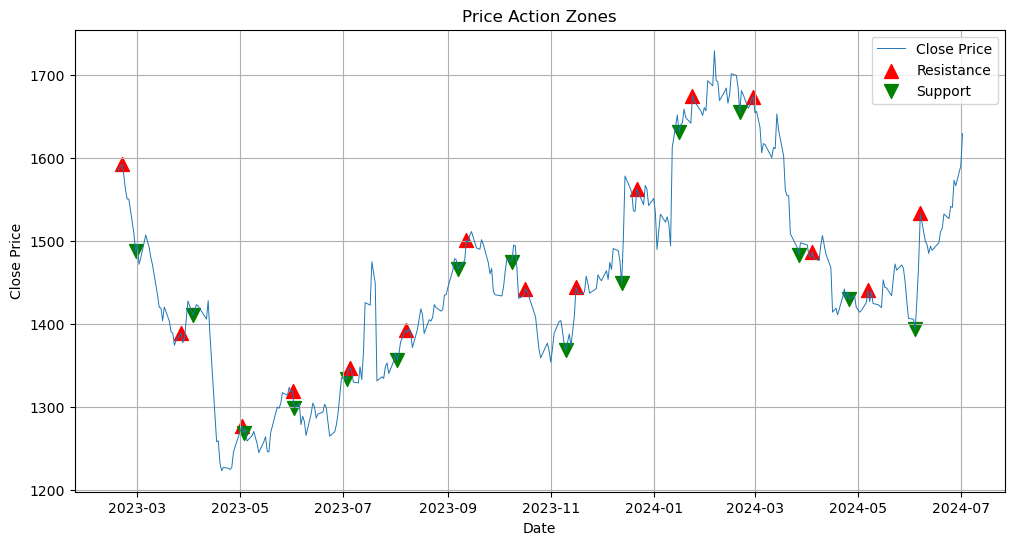

In [35]:
def identify_price_action_zones(df, reverse_threshold, min_distance=timedelta(days=30)):
    df = df.copy()
    zones = []
    last_support = None
    last_resistance = None

    for i in range(1, len(df) - 1):
        if df['close'].iloc[i] > df['close'].iloc[i - 1] and df['close'].iloc[i] > df['close'].iloc[i + 1]:
            if last_resistance is None or (df.index[i] - last_resistance) >= min_distance:
                zones.append((df.index[i], df['close'].iloc[i], 'resistance'))
                last_resistance = df.index[i]
        
        elif df['close'].iloc[i] < df['close'].iloc[i - 1] and df['close'].iloc[i] < df['close'].iloc[i + 1]:
            if last_support is None or (df.index[i] - last_support) >= min_distance:
                zones.append((df.index[i], df['close'].iloc[i], 'support'))
                last_support = df.index[i]
        
        elif abs(df['close'].iloc[i] - df['close'].iloc[i - 1]) / df['close'].iloc[i - 1] >= reverse_threshold and \
             abs(df['close'].iloc[i + 1] - df['close'].iloc[i]) / df['close'].iloc[i] >= reverse_threshold:
            if df['close'].iloc[i] > df['close'].iloc[i - 1] and df['close'].iloc[i + 1] < df['close'].iloc[i]:
                if last_resistance is None or (df.index[i] - last_resistance) >= min_distance:
                    zones.append((df.index[i], df['close'].iloc[i], 'resistance'))
                    last_resistance = df.index[i]
            elif df['close'].iloc[i] < df['close'].iloc[i - 1] and df['close'].iloc[i + 1] > df['close'].iloc[i]:
                if last_support is None or (df.index[i] - last_support) >= min_distance:
                    zones.append((df.index[i], df['close'].iloc[i], 'support'))
                    last_support = df.index[i]
    return zones

def align_price_action_zones(zones, price_level_threshold):
    support_levels = {}
    resistance_levels = {}
    
    for zone in zones:
        price_level = round(zone[1], 2)
        if zone[2] == 'support':
            if price_level not in support_levels:
                support_levels[price_level] = []
            support_levels[price_level].append(zone)
        elif zone[2] == 'resistance':
            if price_level not in resistance_levels:
                resistance_levels[price_level] = []
            resistance_levels[price_level].append(zone)
    
    aligned_zones = []
    for level in support_levels:
        if len(support_levels[level]) >= price_level_threshold:
            aligned_zones.extend(support_levels[level])
    
    for level in resistance_levels:
        if len(resistance_levels[level]) >= price_level_threshold:
            aligned_zones.extend(resistance_levels[level])
    
    return aligned_zones

# Assuming signals_df is your DataFrame
# Downsample the DataFrame
#downsampled_df = signals_df.resample('1D').last().dropna()

# Identify price action zones with a minimum distance between them
price_action_zones = identify_price_action_zones(signals_df, reverse_threshold=0.10, min_distance=timedelta(days=30))

plt.figure(figsize=(12, 6))
plt.plot(signals_df.index, signals_df['close'], label='Close Price', linewidth=0.7)

# Plot identified zones
for zone in price_action_zones:
    if zone[2] == 'resistance':
        plt.scatter(zone[0], zone[1], color='red', marker='^', s=100, label='Resistance' if 'Resistance' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif zone[2] == 'support':
        plt.scatter(zone[0], zone[1], color='green', marker='v', s=100, label='Support' if 'Support' not in plt.gca().get_legend_handles_labels()[1] else "")

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Price Action Zones')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
fig = go.Figure(data=[go.Candlestick(x=signals_df.index,
                                     open=signals_df['open'],
                                     high=signals_df['high'],
                                     low=signals_df['low'],
                                     close=signals_df['close'])])

# Add support and resistance points
for zone in price_action_zones:
    if zone[2] == 'resistance':
        fig.add_trace(go.Scatter(x=[zone[0]], y=[zone[1]], mode='markers', marker=dict(color='red', size=10, symbol='triangle-up'), name='Resistance'))
    elif zone[2] == 'support':
        fig.add_trace(go.Scatter(x=[zone[0]], y=[zone[1]], mode='markers', marker=dict(color='green', size=10, symbol='triangle-down'), name='Support'))

# Update layout
fig.update_layout(title='Price Action Zones', yaxis_title='Close Price', xaxis_title='Date')

fig.show()


In [38]:
signals_df.head()

,open,high,low,close,volume,short_sma,long_sma,macd,signal,macd_histogram,rsi,hammer,shooting_star,bullish_bearish_engulfing
date,,,,,,,,,,,,,,
2023-02-17 00:00:00+05:30,1594.00,1595.00,1575.50,1583.80,2857734,1594.92500,1569.3025,26.198265,29.312318,-3.114052,54.656594,0,0,0
2023-02-20 00:00:00+05:30,1584.95,1603.00,1582.50,1592.45,2417716,1595.16875,1572.6475,25.005630,28.450980,-3.445351,56.335961,0,0,0
2023-02-21 00:00:00+05:30,1598.70,1601.65,1576.00,1579.50,2723288,1590.48125,1574.2225,22.753215,27.311427,-4.558212,53.161520,0,0,1
2023-02-22 00:00:00+05:30,1563.00,1575.00,1555.30,1561.80,3656244,1584.63750,1574.7175,19.317242,25.712590,-6.395348,49.089946,0,0,0
2023-02-23 00:00:00+05:30,1569.85,1569.85,1548.15,1550.70,4766854,1582.54375,1575.1025,15.519630,23.673998,-8.154368,46.675655,0,0,0


<b>Align the price action zones</b>
<p>Identify at least 3 price action zones at the same price level.</p>

Level 1: (Timestamp('2024-05-07 00:00:00+0530', tz='tzoffset(None, 19800)'), 1440.95, 'resistance'), Level 2: (Timestamp('2024-04-26 00:00:00+0530', tz='tzoffset(None, 19800)'), 1430.25, 'support')
Level 1: (Timestamp('2023-10-17 00:00:00+0530', tz='tzoffset(None, 19800)'), 1442.45, 'resistance'), Level 2: (Timestamp('2023-04-03 00:00:00+0530', tz='tzoffset(None, 19800)'), 1410.85, 'support')
Level 1: (Timestamp('2024-02-29 00:00:00+0530', tz='tzoffset(None, 19800)'), 1673.9, 'resistance'), Level 2: (Timestamp('2024-02-21 00:00:00+0530', tz='tzoffset(None, 19800)'), 1655.55, 'support')
Level 1: (Timestamp('2024-01-24 00:00:00+0530', tz='tzoffset(None, 19800)'), 1675.4, 'resistance'), Level 2: (Timestamp('2024-01-16 00:00:00+0530', tz='tzoffset(None, 19800)'), 1631.55, 'support')


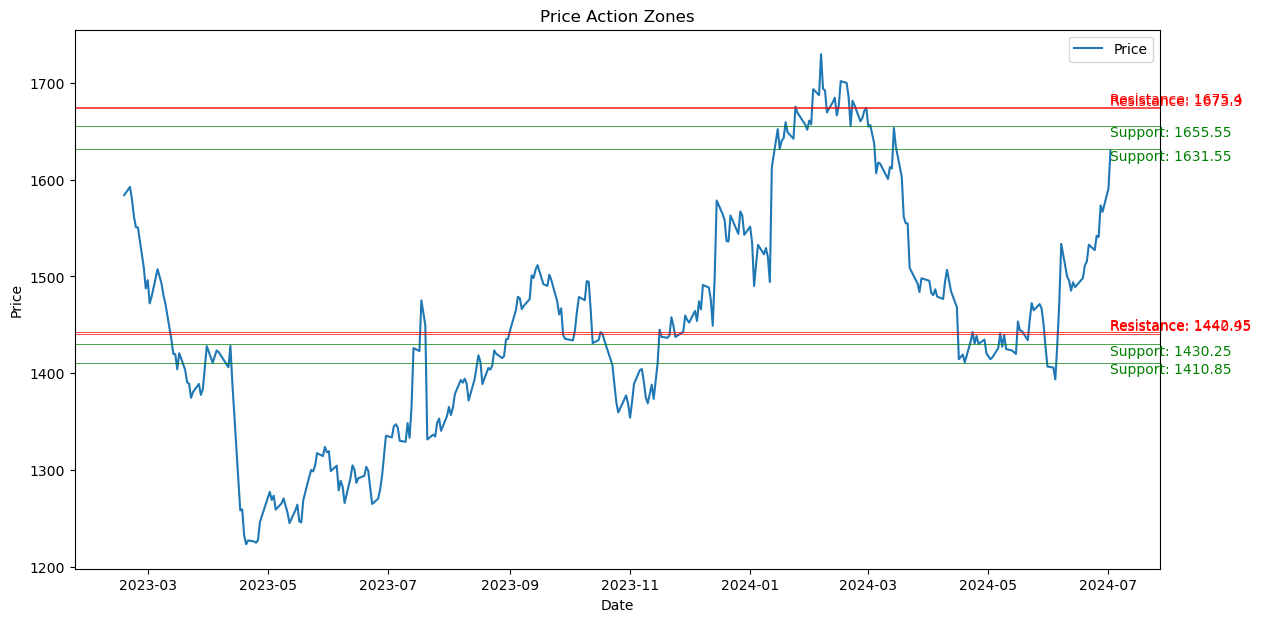

In [50]:
from collections import defaultdict

def align_price_action_zones(zones, price_level_threshold, tolerance=2):
    support_levels = defaultdict(list)
    resistance_levels = defaultdict(list)
    
    # Organize zones into support and resistance levels
    for zone in zones:
        price_level = round(zone[1], 2)  # Round the price level to 2 decimal places
        if zone[2] == 'support':
            support_levels[price_level].append(zone)
        elif zone[2] == 'resistance':
            resistance_levels[price_level].append(zone)
    
    # Helper function to merge levels within tolerance
    def merge_levels(levels, tolerance):
        sorted_levels = sorted(levels.keys())
        merged_levels = {}
        current_level = sorted_levels[0]
        current_zones = levels[current_level]
        
        for level in sorted_levels[1:]:
            if abs(level - current_level) <= tolerance:
                current_zones.extend(levels[level])
            else:
                merged_levels[current_level] = current_zones
                current_level = level
                current_zones = levels[level]
        
        merged_levels[current_level] = current_zones
        return merged_levels
    
    support_levels = merge_levels(support_levels, tolerance)
    resistance_levels = merge_levels(resistance_levels, tolerance)
    
    aligned_supports = []
    aligned_resistances = []
    
    # Process resistance levels
    for level in resistance_levels:
        if len(resistance_levels[level]) >= price_level_threshold:  # Check if the number of zones meets the threshold
            aligned_resistances.extend(resistance_levels[level])  # Add these zones to the aligned_resistances list
    
    # Process support levels
    for level in support_levels:
        if len(support_levels[level]) >= price_level_threshold:  # Check if the number of zones meets the threshold
            aligned_supports.extend(support_levels[level])  # Add these zones to the aligned_supports list
    
    return aligned_supports, aligned_resistances, support_levels, resistance_levels

# Step 3: Find Nearest Support for Each Aligned Resistance and Vice Versa
def find_nearest_levels(aligned_supports, aligned_resistances, support_levels, resistance_levels):
    aligned_zones_with_levels = []
    
    for resistance in aligned_resistances:
        resistance_date = resistance[0]
        resistance_price = resistance[1]
        
        nearest_support = None
        min_diff = float('inf')
        
        for support_level, supports in support_levels.items():
            for support in supports:
                support_date = support[0]
                support_price = support[1]
                
                if support_date < resistance_date and support_price < resistance_price:
                    diff = abs(resistance_price - support_price)
                    
                    if diff < min_diff:
                        min_diff = diff
                        nearest_support = support
        
        if nearest_support:
            aligned_zones_with_levels.append((resistance, nearest_support))
    
    for support in aligned_supports:
        support_date = support[0]
        support_price = support[1]
        
        nearest_resistance = None
        min_diff = float('inf')
        
        for resistance_level, resistances in resistance_levels.items():
            for resistance in resistances:
                resistance_date = resistance[0]
                resistance_price = resistance[1]
                
                if resistance_date > support_date and resistance_price > support_price:
                    diff = abs(support_price - resistance_price)
                    
                    if diff < min_diff:
                        min_diff = diff
                        nearest_resistance = resistance
        
        if nearest_resistance:
            aligned_zones_with_levels.append((support, nearest_resistance))
    
    return aligned_zones_with_levels

# Example usage
price_action_zones = identify_price_action_zones(signals_df, reverse_threshold=0.10, min_distance=timedelta(days=30))
aligned_supports, aligned_resistances, support_levels, resistance_levels = align_price_action_zones(price_action_zones, price_level_threshold=2, tolerance=2)
aligned_zones_with_levels = find_nearest_levels(aligned_supports, aligned_resistances, support_levels, resistance_levels)

for level_1, level_2 in aligned_zones_with_levels:
    print(f"Level 1: {level_1}, Level 2: {level_2}")

def plot_price_action_zones(df, aligned_zones_with_levels):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['close'], label='Price')
    
    for level_1, level_2 in aligned_zones_with_levels:
        if level_1[2] == 'resistance':
            plt.axhline(y=level_1[1], color='r', linestyle='-', linewidth=0.5)
            plt.text(df.index[-1], level_1[1], f'Resistance: {level_1[1]}', color='r', verticalalignment='bottom')
        elif level_1[2] == 'support':
            plt.axhline(y=level_1[1], color='g', linestyle='-', linewidth=0.5)
            plt.text(df.index[-1], level_1[1], f'Support: {level_1[1]}', color='g', verticalalignment='top')
        
        if level_2[2] == 'resistance':
            plt.axhline(y=level_2[1], color='r', linestyle='-', linewidth=0.5)
            plt.text(df.index[-1], level_2[1], f'Resistance: {level_2[1]}', color='r', verticalalignment='bottom')
        elif level_2[2] == 'support':
            plt.axhline(y=level_2[1], color='g', linestyle='-', linewidth=0.5)
            plt.text(df.index[-1], level_2[1], f'Support: {level_2[1]}', color='g', verticalalignment='top')
    
    plt.legend()
    plt.title('Price Action Zones')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

# Plotting
plot_price_action_zones(signals_df, aligned_zones_with_levels)


# Manual Backtesting 

In [ ]:
def generate_buy_sell(df, profit_percentage, loss_percentage,capital):
    df = df.copy()
    pos = False
    trades = []
    buy_price, stop_loss, take_profit, total_profit_loss = 0, 0, 0, 0

    for i in range(len(df)):
        if df['macd'].iloc[i] > df['signal'].iloc[i]  and df['short_sma'].iloc[i] > df['long_sma'].iloc[i] and  pos == False:#and df['rsi'].iloc[i] <= 40  :
            buy_price = df['close'].iloc[i]
            quantity = capital // buy_price
            if quantity == 0:
                print(f"Insufficient capital to buy stocks")
                continue 
            total_buy_price = buy_price*quantity
            stop_loss = buy_price - (buy_price * (loss_percentage/100))
            take_profit = buy_price + (buy_price * (profit_percentage/100))
            buy_date = df.index[i]
            pos = True
            capital -= total_buy_price
            print(f"buy price:{buy_price}\nstop loss:{stop_loss}\ntake profit:{take_profit}\navailable capital: {capital}\nquantity:{quantity}\ndate:{df.index[i]}\n")

            # print(f"Buy at {buy_price} on {df.index[i]}")

        elif pos:
            curr_price = df['close'].iloc[i]

            if (curr_price <= stop_loss) or \
                (curr_price >= take_profit): #and (df['signal'].iloc[i] > df['macd'].iloc[i]) and df['rsi'].iloc[i] > 70) and (df['short_sma'].iloc[i] < df['long_sma'].iloc[i]):
                sell_price = curr_price
                total_sell_price = sell_price*quantity
                capital += total_sell_price
                profit_loss = sell_price - buy_price
                total_profit_loss = total_sell_price - total_buy_price
                trades.append({
                    'buy_date': buy_date,
                    'buy_price':buy_price,
                    'target_profit':take_profit,
                    'stop_loss':stop_loss,
                    'total_buy_price': total_buy_price,
                    'quantity':quantity,
                    'sell_date': df.index[i],
                    'sell_price': sell_price,
                    'total_selling_price':total_sell_price,
                    'profit_loss': profit_loss,
                    'total_profit_loss':total_profit_loss,
                    'available_capital':capital})
                pos = False
                print(f"selling price:{sell_price}\ntotal selling price:{total_sell_price}\nquantity:{quantity}\navailable capital: {capital}\ndate:{df.index[i]}\n")

                # print(f"Sold at {sell_price} on {df.index[i]}, Profit/Loss: {profit_loss:.2f}")
    return trades, total_profit_loss

trades, total_profit_loss = generate_buy_sell(signals_df, profit_percentage=2, loss_percentage=1,capital=10000)

print("\nTrade Summary:")
for trade in trades:
    print(f"Bought at {trade['buy_price']} on {trade['buy_date']} and sold at {trade['sell_price']} on {trade['sell_date']}, Profit/Loss: {trade['profit_loss']:.2f}")

print(f"\nTotal Profit/Loss: {total_profit_loss:.2f}")


buy price:1508.0
stop loss:1492.92
take profit:1538.16
available capital: 952.0
quantity:6.0
date:2024-03-28 12:15:00+05:30

selling price:1490.4
total selling price:8942.400000000001
quantity:6.0
available capital: 9894.400000000001
date:2024-03-28 14:15:00+05:30

buy price:1495.25
stop loss:1480.2975
take profit:1525.155
available capital: 922.9000000000015
quantity:6.0
date:2024-03-28 15:15:00+05:30

selling price:1471.15
total selling price:8826.900000000001
quantity:6.0
available capital: 9749.800000000003
date:2024-04-04 09:15:00+05:30

buy price:1481.3
stop loss:1466.4869999999999
take profit:1510.926
available capital: 862.0000000000036
quantity:6.0
date:2024-04-05 11:15:00+05:30

selling price:1466.05
total selling price:8796.3
quantity:6.0
available capital: 9658.300000000003
date:2024-04-15 10:15:00+05:30

buy price:1428.5
stop loss:1414.215
take profit:1457.07
available capital: 1087.300000000003
quantity:6.0
date:2024-04-22 13:15:00+05:30

selling price:1413.7
total sellin

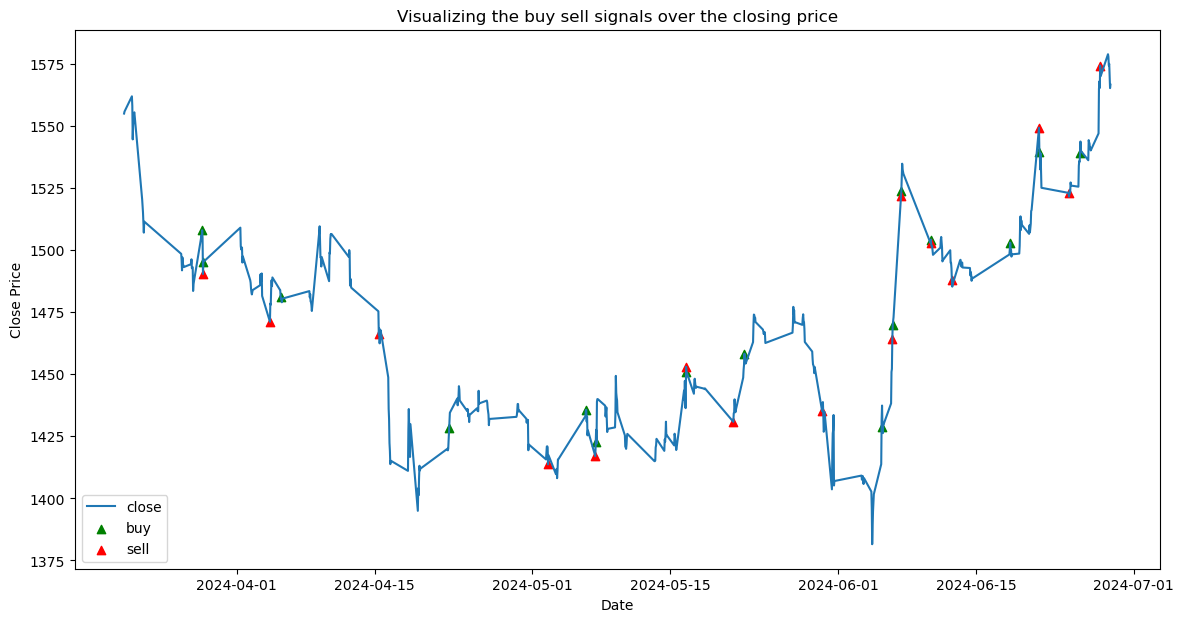

In [ ]:
buy_signals = [trade['buy_price'] for trade in trades]
sell_signals = [trade['sell_price'] for trade in trades]
sell_time = [trade['sell_date'] for trade in trades]
buy_time = [trade['buy_date'] for trade in trades]
plt.figure(figsize=(14, 7))
plt.plot(signals_df.index,signals_df['close'],label='close')
plt.scatter(buy_time,buy_signals,marker='^',color='green',label='buy',alpha=1)
plt.scatter(sell_time,sell_signals,marker='^',color='red',label='sell',alpha=1)
plt.title('Visualizing the buy sell signals over the closing price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
trades_df = pd.DataFrame(trades)
trades_df['buy_date'] = pd.to_datetime(trades_df['buy_date'])
trades_df['sell_date'] = pd.to_datetime(trades_df['sell_date'])
print(len(trades_df[trades_df['profit_loss'] > 0]))
trades_df[trades_df['profit_loss'] > 0]

5


,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital
5,2024-05-07 10:15:00+05:30,1422.85,1451.307,1408.6215,8537.1,6.0,2024-05-16 14:15:00+05:30,1453.00,8718.0,30.15,180.9,9638.2
8,2024-06-05 12:15:00+05:30,1428.95,1457.529,1414.6605,8573.7,6.0,2024-06-06 12:15:00+05:30,1464.20,8785.2,35.25,211.5,9590.5
9,2024-06-06 13:15:00+05:30,1469.95,1499.349,1455.2505,8819.7,6.0,2024-06-07 09:15:00+05:30,1521.80,9130.8,51.85,311.1,9901.6
12,2024-06-18 11:15:00+05:30,1503.00,1533.060,1487.9700,9018.0,6.0,2024-06-21 09:15:00+05:30,1549.30,9295.8,46.30,277.8,9953.8
14,2024-06-25 13:15:00+05:30,1539.10,1569.882,1523.7090,9234.6,6.0,2024-06-27 14:15:00+05:30,1574.35,9446.1,35.25,211.5,10065.7


In [ ]:
trades_df[trades_df['profit_loss'] < 0]

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital
0,2024-03-28 12:15:00+05:30,1508.00,1538.160,1492.9200,9048.0,6.0,2024-03-28 14:15:00+05:30,1490.40,8942.4,-17.60,-105.6,9894.4
1,2024-03-28 15:15:00+05:30,1495.25,1525.155,1480.2975,8971.5,6.0,2024-04-04 09:15:00+05:30,1471.15,8826.9,-24.10,-144.6,9749.8
2,2024-04-05 11:15:00+05:30,1481.30,1510.926,1466.4870,8887.8,6.0,2024-04-15 10:15:00+05:30,1466.05,8796.3,-15.25,-91.5,9658.3
3,2024-04-22 13:15:00+05:30,1428.50,1457.070,1414.2150,8571.0,6.0,2024-05-02 14:15:00+05:30,1413.70,8482.2,-14.80,-88.8,9569.5
4,2024-05-06 11:15:00+05:30,1435.70,1464.414,1421.3430,8614.2,6.0,2024-05-07 09:15:00+05:30,1417.00,8502.0,-18.70,-112.2,9457.3
6,2024-05-16 15:15:00+05:30,1451.00,1480.020,1436.4900,8706.0,6.0,2024-05-21 09:15:00+05:30,1430.85,8585.1,-20.15,-120.9,9517.3
7,2024-05-22 12:15:00+05:30,1458.30,1487.466,1443.7170,8749.8,6.0,2024-05-30 09:15:00+05:30,1435.25,8611.5,-23.05,-138.3,9379.0
10,2024-06-07 10:15:00+05:30,1524.00,1554.480,1508.7600,9144.0,6.0,2024-06-10 09:15:00+05:30,1502.85,9017.1,-21.15,-126.9,9774.7
11,2024-06-10 10:15:00+05:30,1504.25,1534.335,1489.2075,9025.5,6.0,2024-06-12 13:15:00+05:30,1487.80,8926.8,-16.45,-98.7,9676.0
13,2024-06-21 10:15:00+05:30,1539.65,1570.443,1524.2535,9237.9,6.0,2024-06-24 09:15:00+05:30,1523.05,9138.3,-16.60,-99.6,9854.2


In [ ]:
# trades_df.head

In [ ]:
trades_df.tail()

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital
0,2024-03-28 12:15:00+05:30,1508.0,1538.160,1523.080,9048.0,6.0,2024-06-21 09:15:00+05:30,1549.3,9295.8,41.3,247.8,10247.8
1,2024-06-21 15:15:00+05:30,1525.1,1555.602,1540.351,9150.6,6.0,2024-06-27 11:15:00+05:30,1564.9,9389.4,39.8,238.8,10486.6


In [ ]:
trades_df

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital
0,2024-03-28 12:15:00+05:30,1508.00,1538.160,1492.9200,9048.0,6.0,2024-03-28 14:15:00+05:30,1490.40,8942.4,-17.60,-105.6,9894.4
1,2024-03-28 15:15:00+05:30,1495.25,1525.155,1480.2975,8971.5,6.0,2024-04-04 09:15:00+05:30,1471.15,8826.9,-24.10,-144.6,9749.8
2,2024-04-05 11:15:00+05:30,1481.30,1510.926,1466.4870,8887.8,6.0,2024-04-15 10:15:00+05:30,1466.05,8796.3,-15.25,-91.5,9658.3
3,2024-04-22 13:15:00+05:30,1428.50,1457.070,1414.2150,8571.0,6.0,2024-05-02 14:15:00+05:30,1413.70,8482.2,-14.80,-88.8,9569.5
4,2024-05-06 11:15:00+05:30,1435.70,1464.414,1421.3430,8614.2,6.0,2024-05-07 09:15:00+05:30,1417.00,8502.0,-18.70,-112.2,9457.3
5,2024-05-07 10:15:00+05:30,1422.85,1451.307,1408.6215,8537.1,6.0,2024-05-16 14:15:00+05:30,1453.00,8718.0,30.15,180.9,9638.2
6,2024-05-16 15:15:00+05:30,1451.00,1480.020,1436.4900,8706.0,6.0,2024-05-21 09:15:00+05:30,1430.85,8585.1,-20.15,-120.9,9517.3
7,2024-05-22 12:15:00+05:30,1458.30,1487.466,1443.7170,8749.8,6.0,2024-05-30 09:15:00+05:30,1435.25,8611.5,-23.05,-138.3,9379.0
8,2024-06-05 12:15:00+05:30,1428.95,1457.529,1414.6605,8573.7,6.0,2024-06-06 12:15:00+05:30,1464.20,8785.2,35.25,211.5,9590.5
9,2024-06-06 13:15:00+05:30,1469.95,1499.349,1455.2505,8819.7,6.0,2024-06-07 09:15:00+05:30,1521.80,9130.8,51.85,311.1,9901.6


# Computing the absolute returns 


absolute returns = (net return/cost of investment) * 100 % 

In [ ]:
def compute_abs_returns(buy_price,sell_price):
    diff = sell_price - buy_price
    roi = (diff/buy_price) 
    return roi

In [ ]:
trades_df['absolute_returns'] = trades_df.apply(lambda row: compute_abs_returns(row['buy_price'],row['sell_price']),axis=1) 
trades_df.head()

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital,absolute_returns
0,2024-03-28 12:15:00+05:30,1508.0,1538.160,1523.080,9048.0,6.0,2024-06-21 09:15:00+05:30,1549.3,9295.8,41.3,247.8,10247.8,0.027387
1,2024-06-21 15:15:00+05:30,1525.1,1555.602,1540.351,9150.6,6.0,2024-06-27 11:15:00+05:30,1564.9,9389.4,39.8,238.8,10486.6,0.026097


In [ ]:
total_abs_return = trades_df['absolute_returns'].sum()

In [ ]:
print(f"The absolute returns of the trading strategy: {total_abs_return:.2f}")

The absolute returns of the trading strategy: 0.05


In [ ]:
trades_df.to_csv('trades.csv')

# Computing beta

In [ ]:
nifty_50_df = fetchOHLCExtended('NIFTY 50', "01-01-2019", 'hour')
infy_df = fetchOHLCExtended('INFY', "01-01-2019", 'hour')

In [ ]:
def compute_beta(nifty_50_df, ohlc_df):
    nifty_50_df.sort_index(inplace=True)
    ohlc_df.sort_index(inplace=True)
    
    nifty_50_df['returns'] = nifty_50_df['close'].pct_change()
    ohlc_df['returns'] = ohlc_df['close'].pct_change()
    
    nifty_50_df.dropna(subset=['returns'], inplace=True)
    ohlc_df.dropna(subset=['returns'], inplace=True)
    
    nifty_50_df.rename(columns={'returns': 'returns_NIFTY_50'}, inplace=True)
    ohlc_df.rename(columns={'returns': 'returns_STK'}, inplace=True)
    
    merged_df = pd.merge(nifty_50_df[['returns_NIFTY_50']], ohlc_df[['returns_STK']], left_index=True, right_index=True)
    
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_df.dropna(inplace=True)
    
    covariance = merged_df['returns_STK'].cov(merged_df['returns_NIFTY_50'])
    variance = merged_df['returns_NIFTY_50'].var()
    beta = covariance / variance
    return beta


In [ ]:
beta = compute_beta(nifty_50_df, infy_df)
print(f"The beta value of Infosys stock: {beta:.2f}")

The beta value of Infosys stock: 0.79


# Computing the sharpe ratio 

Sharpe ratio = [Fund Return – Risk-Free Return]/Standard Deviation of the fund

In [ ]:
nifty_50_avg_df = nifty_50_df.copy()

In [ ]:
# Calculate the average market return 

def compute_avg_market_return(df):
    df = df.copy()
    df.sort_index(inplace=True)
    df['returns'] = df['close'].pct_change()
    df.dropna(subset=['returns'], inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    average_market_return = df['returns'].mean()
    annualized_market_return = (1 + average_market_return) ** 252 - 1
    return annualized_market_return

avg_market_return = compute_avg_market_return(nifty_50_avg_df)
print(f"NIFTY 50 market return value (2015-2024): {avg_market_return:.4f}")


def compute_risk_free_returns(avg_market_return,risk_free_rate,beta):
    risk_free_return = risk_free_rate + beta * (avg_market_return - risk_free_rate)
    return risk_free_return

risk_free_return = compute_risk_free_returns(avg_market_return,risk_free_rate=0.07,beta=beta) 
print(f"Risk free return of nifty 50: {risk_free_return:.4f}")



NIFTY 50 market return value (2015-2024): 0.0239
Risk free return of nifty 50: 0.0336


# Computing the win-loss ratio

In [ ]:
def compute_win_loss(df):
    df = df.copy()
    wins = len(df[df['profit_loss'] > 0]) 
    loss = len(df[df['profit_loss'] < 0])
    win_loss_ratio = wins/loss
    return win_loss_ratio

win_loss = compute_win_loss(trades_df)
print(f"Win-loss ratio: {win_loss:.4f}") 

ZeroDivisionError: division by zero

In [ ]:
trades_df[trades_df['profit_loss'] > 0]

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital,absolute_returns
1,2024-03-28 14:15:00+05:30,1490.40,1520.208,1505.3040,8942.40,6.0,2024-03-28 15:15:00+05:30,1495.25,8971.50,4.85,29.10,10010.80,0.003254
8,2024-04-09 12:15:00+05:30,1497.10,1527.042,1512.0710,8982.60,6.0,2024-04-09 13:15:00+05:30,1497.20,8983.20,0.10,0.60,9857.80,0.000067
9,2024-04-09 14:15:00+05:30,1493.40,1523.268,1508.3340,8960.40,6.0,2024-04-09 15:15:00+05:30,1497.25,8983.50,3.85,23.10,9880.90,0.002578
10,2024-04-10 09:15:00+05:30,1487.50,1517.250,1502.3750,8925.00,6.0,2024-04-10 10:15:00+05:30,1499.05,8994.30,11.55,69.30,9950.20,0.007765
11,2024-04-10 11:15:00+05:30,1498.65,1528.623,1513.6365,8991.90,6.0,2024-04-10 12:15:00+05:30,1504.55,9027.30,5.90,35.40,9985.60,0.003937
12,2024-04-12 09:15:00+05:30,1497.25,1527.195,1512.2225,8983.50,6.0,2024-04-12 10:15:00+05:30,1500.00,9000.00,2.75,16.50,10002.10,0.001837
13,2024-04-22 13:15:00+05:30,1428.50,1457.070,1442.7850,9999.50,7.0,2024-04-22 14:15:00+05:30,1431.85,10022.95,3.35,23.45,10025.55,0.002345
14,2024-04-22 15:15:00+05:30,1434.50,1463.190,1448.8450,8607.00,6.0,2024-04-23 09:15:00+05:30,1440.25,8641.50,5.75,34.50,10060.05,0.004008
15,2024-04-23 10:15:00+05:30,1437.50,1466.250,1451.8750,8625.00,6.0,2024-04-23 11:15:00+05:30,1440.50,8643.00,3.00,18.00,10078.05,0.002087
16,2024-04-23 12:15:00+05:30,1440.90,1469.718,1455.3090,8645.40,6.0,2024-04-23 13:15:00+05:30,1445.20,8671.20,4.30,25.80,10103.85,0.002984


In [ ]:
trades_df[trades_df['profit_loss'] < 0]

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital,absolute_returns
0,2024-03-28 12:15:00+05:30,1508.00,1538.160,1523.0800,9048.00,6.0,2024-03-28 13:15:00+05:30,1504.95,9029.70,-3.05,-18.30,9981.70,-0.002023
2,2024-04-01 09:15:00+05:30,1509.05,1539.231,1524.1405,9054.30,6.0,2024-04-01 10:15:00+05:30,1501.60,9009.60,-7.45,-44.70,9966.10,-0.004937
3,2024-04-01 11:15:00+05:30,1500.35,1530.357,1515.3535,9002.10,6.0,2024-04-01 12:15:00+05:30,1500.15,9000.90,-0.20,-1.20,9964.90,-0.000133
4,2024-04-01 13:15:00+05:30,1501.05,1531.071,1516.0605,9006.30,6.0,2024-04-01 14:15:00+05:30,1495.00,8970.00,-6.05,-36.30,9928.60,-0.004031
5,2024-04-01 15:15:00+05:30,1497.50,1527.450,1512.4750,8985.00,6.0,2024-04-02 09:15:00+05:30,1487.90,8927.40,-9.60,-57.60,9871.00,-0.006411
6,2024-04-05 11:15:00+05:30,1481.30,1510.926,1496.1130,8887.80,6.0,2024-04-05 12:15:00+05:30,1480.30,8881.80,-1.00,-6.00,9865.00,-0.000675
7,2024-04-05 13:15:00+05:30,1480.30,1509.906,1495.1030,8881.80,6.0,2024-04-05 14:15:00+05:30,1479.00,8874.00,-1.30,-7.80,9857.20,-0.000878
17,2024-04-23 14:15:00+05:30,1443.95,1472.829,1458.3895,8663.70,6.0,2024-04-23 15:15:00+05:30,1439.45,8636.70,-4.50,-27.00,10076.85,-0.003116
19,2024-04-24 11:15:00+05:30,1435.00,1463.700,1449.3500,10045.00,7.0,2024-04-24 12:15:00+05:30,1433.05,10031.35,-1.95,-13.65,10069.15,-0.001359
20,2024-04-24 13:15:00+05:30,1433.90,1462.578,1448.2390,10037.30,7.0,2024-04-24 14:15:00+05:30,1430.75,10015.25,-3.15,-22.05,10047.10,-0.002197
